In [1]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt



# Tutorial 01: What is Model Predictive Control
Model Predictive control (MPC) is a control technique where the control input that is applied to the system minimizes the cost of a predicted trajectory over a finite time into the future.
We can describe the simplest form of this optimal control problem (OCP) that is solved at every timestep as


\begin{align} 
&\underset{\mathbf{u}^0_N \in \mathcal{U}_N}{\operatorname{argmin}} J_N(\mathbf{x}_N,\mathbf{u}_N) = \sum_{k=0}^{N-1} \ell(x(k),u(k)) + V_f(x(N))\label{eq:ocp} \tag{OCP}\\
&\text{s.t.}&\\
&\qquad x(k+1) = f(x(k),u(k)) \quad \forall k=0\ldots N-1 \tag{1} \label{eq:dyn_con}\\
&\qquad x(0) = x_0 \tag{2} \label{eq:ic_con}\\
& \qquad x(k) \in \mathcal{X} \quad \forall k=0\ldots N \tag{3} \label{eq:state_con}\\
& \qquad u(k) \in \mathcal{U} \quad \forall k=0\ldots N-1 \tag{4} \label{eq:in_con}\\ 
& \qquad x(N) \in \mathcal{X}_f \tag{5} \label{eq:term_con}
\end{align}

where $x(k+1) = f(x(k),u(k))$ are the discrete time dynamics of ths system. Trajectories are represented with  $\mathbf{x}_N = [x(0), x(1),\ldots,x(N)]$, with $x(k) \in \mathcal{X} \subseteq \mathbb{R}^{n_x}$, and the corresponding control input sequence that generates $\mathbf{x}_N$ is $\mathbf{u}_N = [u(0), u(1),\ldots,u(N-1)]$ with $u(k) \in \mathcal{U} \subseteq \mathbb{R}^{n_u}$.
Note that $\mathbf{u}_N$ has one less elemenet that $\mathbf{x}_N$ and that $\mathbf{u}^0_N$ and $\mathbf{x}^0_N$ correspond to the optimized sequences.
The objective function $J_N : \mathcal{X}_N \times \mathcal{U}_N \rightarrow \mathbb{R}_{\geq 0}$ specifies the cost associated with a specific trajectory and control sequence. It is generally composed of a lostt function $\ell : \mathcal{X}\times\mathcal{U} : \rightarrow \mathbb{R}_{\geq 0}$, and a terminal state state cost, which will be discussed later.

The optimization problem serves to find the control sequence of length $N$ that minimizes the cost $J_N$, subjext to a number of constraints. First, the system dynamics must be obeyed using the dynamics constraint \eqref{eq:dyn_con}. The initial conditions constraint \eqref{eq:ic_con} ensure $x(0)$ is equal to the initial conditions $x_0$. Constraints \eqref{eq:state_con} and \eqref{eq:in_con} ensure the state and input stay within constrained regions. Here, we are using the notation $\mathcal{X}$ and $\mathcal{U}$ to represent the unconstrained regions and $\mathbb{X}$ and $\mathbb{U}$ to represent the constrained regions. Generally, $\mathcal{X} \subseteq \mathbb{R}^{n_x}$ and $\mathcal{U} \subseteq \mathbb{R}^{n_u}$, and \eqref{eq:term_con} ensures the final state lives within a defined terminal state region. We will see, in later tutorials, how this optimization problem can be modified to guarantee stability and recursive feasability. We will also see how to use terminal constraints and termincal costs to stabilize the controller, and how the problem can be formulated to be robust to noise and uncertainty.

The generic MPC algorithm is provied below.

### MPC Algorithm:
1. Determine current state $x(k)$.
2. Solve \eqref{eq:ocp} to get the optimal control sequence $\mathbf{u}^0_N$.
3. Use the feedback law $u(k) = \kappa(x(k)) = \mathbf{u}^0_N[0]$ that uses only the first element of $\mathbf{u}^0_N$  to compute the next state $x(k+1) = f(x(k),u(k))$.
4. repeate until goal state is converged or \eqref{eq:ocp} is infeasible.


Yes, it's really that simple. There are many, many variations, but at it's core, this is how to control a system using MPC.






## Inverted Pendulum
Here we introduce the inverted pendulum model we will use in the tutorial examples. The inverted pendulum is one of the simpler nonlinear systems, allowing us to show how MPC works with nonlinear systems, without requiring extremely complex dynamics.
<img src="./figs/inverted_pend.jpeg" alt="Drawing" style="width: 200px;"/>
Using Newtons laws, we can derive the dyanmics

\begin{equation}
\ddot{\theta} = -\frac{mgl}{I}\sin(\theta) + \frac{\tau}{I}.
\end{equation}

Taking $I = 1/3 ml^2$, assuming the pendulum is a rod, and using $x_1 := \theta$ and $x_2 := \dot{\theta}$, we have

$$
\dot{x} = \begin{bmatrix} \dot{x_1} \\ \dot{x_2} \end{bmatrix} = \begin{bmatrix} x_2 \\ -\frac{3g}{l}\sin(x_1) + \frac{3u}{ml^2}\end{bmatrix}. 
$$

Let's now formulate this using CasADI (https://web.casadi.org/). CasADI is a symbolic language with algorithmic differentiation that is tailed to nonlinear optimization problems. We will use their Python API throughout this tutorial.

In [2]:
def inverted_pendulum():
    # symbolic state variables
    x1 = MX.sym('x1')
    x2 = MX.sym('x2')
    u = MX.sym('u')

    # dynamic model parameters
    m = 1.0
    g = 9.8
    l = 1.0
    I = m*l**2/3.0
    dt = 0.01

    # dynamics equations
    x_dot = vertcat(x2, -3*g/(2*l)*sin(x1) + u/I) # dynamics equation
    fc = Function('fc', [x1, x2, u], [x_dot]) # continuous dynamics

    # integrator to define discrete dynamics
    x = vertcat(x1, x2)
    dae = {'x': x, 'p': u, 'ode': x_dot} # define the differential algebraic equation to be integrated
    opts = {'tf': dt} #specify the integration time
    F = integrator('F', 'cvodes', dae, opts) # Discrete Dynamics integrated over dt
    
    return F, dt


F, dt = inverted_pendulum() 

## Unconstrained MPC formulated

In the unconstrained problem, $\mathcal{X} = \mathbb{R}^{n_x}$ and $\mathcal{U} = \mathbb{R}^{n_u}$. In this specific instance, we will ignore any terminal constraints, i.e., $\mathcal{X}_f = \mathbb{R}^{n_x}$ and assume there is not terminal cost, i.e., $V_f(x) = 0$. A standard choice for the loss function $\ell(x,u)$ is the quadratic loss function 

$$
\ell(x,u) = x^TQx + u^TRu.
$$

This formulation has some important qualities which will be elucidated when presenting the stability of MPC. Using this cost function, we can formulate an MPC problem using CasADI as follows:

In [14]:
def setup_optim(f, N, Q, R, verbose=False):
    """
    Setup the optimizer using the CasADI framework.
    args:
        f [casadi.function] : Discrete dynamics function.
        N [int] : time horizon
        Q [np.array] : State gain matrix
        R [np.array] : Input gain matrix
        
    Return:
        opti_dict [dict] : Dictionary containing relevant casadi Opti parameters
    """
    opti = casadi.Opti()         # define optimizer
    X = opti.variable(2, N+1)    # State variable
    U = opti.variable(1, N)      # Input variable
    P = opti.parameter(2, 2)     # Opti parameter: initial condition and goal location
    
    # Objective function
    J = 0
    for i in range(N):
        J += mtimes((X[:, i]-P[:,1]).T, mtimes(Q, (X[:, i]-P[:,1]))) + mtimes(U[:, i].T, mtimes(R, U[:, i]))

    opti.minimize(J)
    for i in range(N):
        opti.subject_to(X[:, i + 1] == f(x0=X[:, i], p=U[i])['xf']) # dynamics constraints

    opti.subject_to(X[:, 0] == P[:, 0]) # initial condition constraint
    if not(verbose):
        opts = {"verbose_init" : False,
                "verbose" : False,
                "print_time" : False,
                "ipopt.print_level" : 0}
    else:
        opts = {}
    opti.solver('ipopt', opts) # Using IPOPT solver 

    opti_dict = {'opti' : opti,
                 'X' : X,
                 'U' : U,
                 'P' : P,
                 'J' : J}
    
    return opti_dict

def solve_optim(opti_dict, x0, xg):
    """
    Solve the optimization problem.
    args:
        opti_dict [dict] : opti dict from setup_optim
        x0 [np.array] : Starting point
        xg [np.array] : goal state
    """

    opti = opti_dict['opti']
    X = opti_dict['X']
    U = opti_dict['U']
    P = opti_dict['P']
    J = opti_dict['J']

    opti.set_value(P[:,0], x0) # Assign the initial state to first column of parameter P
    opti.set_value(P[:,1], xg) # assign the goal state to the second column of parameter P

    
    sol = opti.solve() # Solve the optimization problem

    return sol.value(X), sol.value(U), sol.value(J) # retrieve the X and U

Now lets implement an algorithm for unconstraint MPC

In [21]:
def unconstrainted_mpc(F, N, x0, xg, Q, R, dt, tol=1e-3, MAX_STEPS=1000, plot=False, print_level=0):
    """
    Simple implementation of the unconstrainted MPC problem.
    args:
        f [casadi.function] : Discrete dynamics function.
        N [int] : time horizon
        x0 [np.array] : Starting point
        xg [np.array] : goal state
        Q [np.array] : State gain matrix
        R [np.array] : Input gain matrix
        tol [float] : tolerance to solve position wrt to goal
        MAX_STEPS [int] : max number of OCP iterations
    """
   
    nu = R.shape[0]
    nx = Q.shape[0]

    if(print_level > 1):
        verbose = True
    else:
        verbose = False
    opti_dict = setup_optim(F, N, Q, R, verbose=verbose) # setup the CasADI optimizer

    #x = x0.reshape((2,1)) # set initial state
    x = x0 # set initial state
    all_x = [x]
    all_u = []
    stage_costs = []
    
    step = 0
    while( np.linalg.norm(x-xg) > tol and step < MAX_STEPS): 
        # loop until goal is reached within tolerance or max steps reached
        X, U, stage_cost = solve_optim(opti_dict, x, xg) # solve the current time step
        u = np.array([U[0]]) # feedback law to get the current system input from optimized U
        if(print_level > 0):
            print('')
            print("Step: %s" % step)
            print('State: %0.3f  %0.3f,  Input: %0.3f, Stage Cost: %0.3f' % (x[0], x[1], u, stage_cost))
        
        x = np.squeeze(F(x0=x, p=u)['xf'].toarray()) # step the system forward (x0 and p arguments are defined by CasADI)
        
        #record state and input
        all_x += [x]
        all_u += [u]
        stage_costs += [stage_cost]
        
        step += 1

    # plot everything!
    all_x = np.array(all_x)
    all_u = np.array(all_u)
    stage_costs = np.array(stage_costs)
    N_steps = all_x.shape[0]
    all_x = all_x.reshape((N_steps,nx))
    all_u = all_u.reshape((N_steps-1,nu))
    stage_costs = stage_costs.reshape((N_steps-1))
    if(plot):
        t = np.arange(N_steps)*dt
        plt.plot(t, all_x[:,0])
        plt.plot(t, all_x[:,1])
        plt.plot(t[0:-1], all_u[:,0])
        plt.legend(['Theta','Theta_dot','input'])
        plt.show()
    
    return all_x, all_u, stage_costs

Now, lets run MPC to solve the inverted pendulum example. We will limit ourselves to a random initial condition close to the equilibirum and use a time horizon of $N=10$. We will use gain matrices $Q = 10\mathrm{I}_{n_x}$ and $R = \mathrm{I}_{n_u}$. The problem will take some time to run. Using IPOPT, each iteration took my computer about 70ms to solve and about 240 iterations. Of course, changing the time step and time-horzion greatly changes the computational time.


Step: 0
State: -0.117  -0.136,  Input: 0.123, Stage Cost: 2.004

Step: 1
State: -0.118  -0.115,  Input: 0.078, Stage Cost: 1.837

Step: 2
State: -0.119  -0.095,  Input: 0.036, Stage Cost: 1.744

Step: 3
State: -0.120  -0.076,  Input: -0.003, Stage Cost: 1.713

Step: 4
State: -0.121  -0.059,  Input: -0.040, Stage Cost: 1.732

Step: 5
State: -0.121  -0.042,  Input: -0.075, Stage Cost: 1.792

Step: 6
State: -0.122  -0.027,  Input: -0.108, Stage Cost: 1.884

Step: 7
State: -0.122  -0.012,  Input: -0.138, Stage Cost: 2.003

Step: 8
State: -0.122  0.002,  Input: -0.166, Stage Cost: 2.140

Step: 9
State: -0.122  0.015,  Input: -0.193, Stage Cost: 2.292

Step: 10
State: -0.122  0.027,  Input: -0.217, Stage Cost: 2.452

Step: 11
State: -0.121  0.038,  Input: -0.240, Stage Cost: 2.618

Step: 12
State: -0.121  0.049,  Input: -0.261, Stage Cost: 2.785

Step: 13
State: -0.120  0.059,  Input: -0.281, Stage Cost: 2.951

Step: 14
State: -0.120  0.068,  Input: -0.299, Stage Cost: 3.114

Step: 15
State


Step: 131
State: -0.008  0.026,  Input: -0.065, Stage Cost: 0.083

Step: 132
State: -0.008  0.025,  Input: -0.063, Stage Cost: 0.078

Step: 133
State: -0.008  0.025,  Input: -0.061, Stage Cost: 0.074

Step: 134
State: -0.008  0.024,  Input: -0.059, Stage Cost: 0.070

Step: 135
State: -0.008  0.023,  Input: -0.058, Stage Cost: 0.066

Step: 136
State: -0.007  0.023,  Input: -0.056, Stage Cost: 0.062

Step: 137
State: -0.007  0.022,  Input: -0.055, Stage Cost: 0.058

Step: 138
State: -0.007  0.021,  Input: -0.053, Stage Cost: 0.055

Step: 139
State: -0.007  0.021,  Input: -0.051, Stage Cost: 0.052

Step: 140
State: -0.006  0.020,  Input: -0.050, Stage Cost: 0.049

Step: 141
State: -0.006  0.020,  Input: -0.049, Stage Cost: 0.046

Step: 142
State: -0.006  0.019,  Input: -0.047, Stage Cost: 0.044

Step: 143
State: -0.006  0.019,  Input: -0.046, Stage Cost: 0.041

Step: 144
State: -0.006  0.018,  Input: -0.044, Stage Cost: 0.039

Step: 145
State: -0.005  0.017,  Input: -0.043, Stage Cost: 0

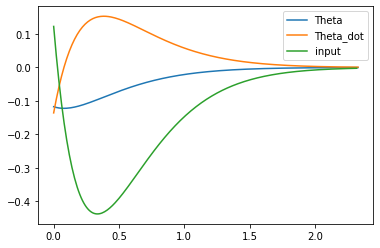

In [23]:
np.random.seed(123412)

N = 10 # Time horizon

# Get initial conditions within bounds
x1_lim = 0.2
x2_lim = 0.2
x_lim = np.array([x1_lim, x2_lim])
x0 = 2*x_lim*np.random.random(2) - x_lim

# define goal
xg = np.zeros(2)

# Gain matrices
Q = np.eye(2)*10
R = np.eye(1)

# Run MPC
mpc_x, mpc_u, mpc_costs = unconstrainted_mpc(F, N, x0, xg, Q, R, dt, plot=True, print_level=1)




Congradulations! You have solved your first MPC problem! Let us now take a look at solving the same problem using a Linear Quadratic Regulator which will give us the optimal solution around the origin.

## Inverted Pendulum Linear Quadratic Regulator

The MPC formulation given above is essentialy a finite-time approximation of the infinite-horizon problem. See [1] Chapter 2.3 and [2] Chapter 3.4 for more details. The infinite-horizon problem is essentially the same as above, however, $J_N$ is replaced by 

$$
J_\infty(\mathbf{x}_\infty, \mathbf{u}_\infty) = \sum_{k=0}^\infty \ell(x(k),u(k)).
$$

Interestingly, it can be shown for Linear Time Invariant (LTI) systems,

$$
x(k+1) = Ax(k) + Bu(k)
$$

that when $\ell(x,u) = x^TQx + u^TRu$, one is able to form an optimal analytical feedback law called the Linear Quadratic Regulator (LQR). First, one assumes that there exists a Lyapunov function of the form $V(x(k)) = x(k)^T P x(k)$, where $P > 0$, $P^T = P$, and can be found by solving the Discrete Algebraic Riccati Equation (DARE):

$$
P = A^T(P - PB(R+B^TPB)^{-1}B^TP)A + Q.
$$

It can then be shown that the feedback law

$$
u(k) = -(R+B^TPB)^{-1}B^TPA x(k)
$$

yields the optimal solution to the infinite-horizon optimal control problem. For nonlinear systems, one is able to linearize their dynamics about an equilibrium, solve the DARE to get P, and formulate the LQR feedback law. The issue that arises for nonlinear systems is that the LQR feedback law only stabilizes the nonlinear system in a local region about the equilibrium (IS IT STILL OPTIMAL?).

There are many packages available to solve the DARE. One can even use CasADI to solve it. Here, we will use the [python control package](https://python-control.readthedocs.io/en/latest/generated/control.dare.html#control.dare). It is a great control package for python that mimics most of the control functionalities found in MATLAB.

First, we must linearize our system about the goal state (0,0) and input 0. We will use CasADIs Jacobian function. Then we will import python control, check controllability, and solve the DARE for P. Note that it also gives us the LQR feedback gain matrix $K$ as well.

Is system controllable? True

Step: 0
State: -0.118  -0.103,  Input: 0.498

Step: 1
State: -0.119  -0.074,  Input: 0.399

Step: 2
State: -0.120  -0.047,  Input: 0.308

Step: 3
State: -0.120  -0.023,  Input: 0.225

Step: 4
State: -0.120  -0.001,  Input: 0.150

Step: 5
State: -0.120  0.019,  Input: 0.081

Step: 6
State: -0.120  0.037,  Input: 0.019

Step: 7
State: -0.119  0.054,  Input: -0.038

Step: 8
State: -0.119  0.069,  Input: -0.089

Step: 9
State: -0.118  0.082,  Input: -0.136

Step: 10
State: -0.117  0.094,  Input: -0.177

Step: 11
State: -0.116  0.105,  Input: -0.215

Step: 12
State: -0.115  0.114,  Input: -0.249

Step: 13
State: -0.114  0.122,  Input: -0.279

Step: 14
State: -0.113  0.130,  Input: -0.306

Step: 15
State: -0.111  0.136,  Input: -0.330

Step: 16
State: -0.110  0.142,  Input: -0.351

Step: 17
State: -0.108  0.147,  Input: -0.370

Step: 18
State: -0.107  0.151,  Input: -0.386

Step: 19
State: -0.105  0.155,  Input: -0.400

Step: 20
State: -0.104  0.158,  Input: -0.


Step: 261
State: -0.000  0.001,  Input: -0.003

Step: 262
State: -0.000  0.001,  Input: -0.003

Step: 263
State: -0.000  0.001,  Input: -0.003

Step: 264
State: -0.000  0.001,  Input: -0.003
(266, 2)
(265, 1)


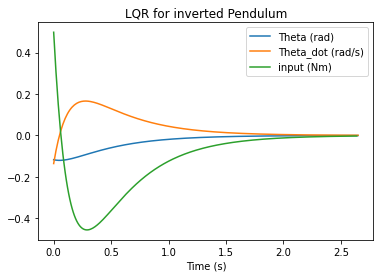

In [6]:
import control



def LQR(Q, R, x0, xg, F, dt, tol=1e-3, MAX_STEPS=1000, plot=False, print_steps=False):
    
    nu = R.shape[0]
    nx = Q.shape[0]
    
    # compute the linearized system about (xg,0)
    Jac = F.jacobian()
    AB = Jac(x0=xg, p=0)['jac']
    A = AB[:,0:2].toarray()
    B = AB[:,2].toarray()
    
    c = control.ctrb(A, B) # check controllability
    print("Is system controllable? %s" %(np.linalg.matrix_rank(c) == 2)) # True
    
    P, closed_loop_evals, K = control.dare(A, B, Q, R) # compute P and the gain matrix K

    x = x0
    all_x = [x]
    all_u = []
    step = 0
    while(np.linalg.norm(x-xg) > tol and step < MAX_STEPS): # while not at the goal location
        u = -np.dot(np.asarray(K),x) # compute Feedback control input
        x = np.squeeze(F(x0=x, p=u)['xf'].toarray()) # step system forward
        all_x += [x]
        all_u += [u]
        if(print_steps):
            print('')
            print("Step: %s" % step)
            print('State: %0.3f  %0.3f,  Input: %0.3f' % (x[0], x[1], u))
        step += 1
    
    # plot everything!
    all_x = np.array(all_x)
    all_u = np.array(all_u)
    N_steps = all_x.shape[0]
    all_x = all_x.reshape((N_steps,nx))
    all_u = all_u.reshape((N_steps-1,nu))
    print(all_x.shape)
    print(all_u.shape)
    t = np.arange(N_steps)*dt
    if(plot):
        plt.plot(t, all_x[:,0])
        plt.plot(t, all_x[:,1])
        plt.plot(t[0:-1], all_u)
        plt.legend(['Theta (rad)','Theta_dot (rad/s)','input (Nm)'])
        plt.title('LQR for inverted Pendulum')
        plt.xlabel('Time (s)')
        plt.show()
    
    return all_x, all_u

lqr_x, lqr_u = LQR(Q, R, x0, xg, F, dt, plot=True, print_steps=True)

Wow, do the MPC and LQR curves ever look similar! Let's plot them on the same axis.

MPC Total cost: 30.632287222861528
LQR Total cost: 29.210740280288483


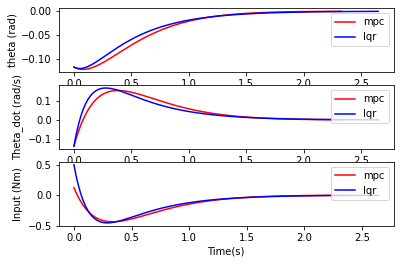

In [7]:
mpc_costs = np.trace(mpc_x @ Q @ mpc_x.transpose()) + np.trace(mpc_u * R * mpc_u.transpose())
lqr_costs = np.trace(lqr_x @ Q @ lqr_x.transpose()) + np.trace(lqr_u * R * lqr_u.transpose())


print("MPC Total cost: %s" %mpc_costs)
print("LQR Total cost: %s" %lqr_costs)

plt.subplot(311)
n1 = np.shape(mpc_x)[0]
t1 = np.arange(n1)*dt
n2 = np.shape(lqr_x)[0]
t2 = np.arange(n2)*dt
plt.plot(t1, mpc_x[:,0],'r')
plt.plot(t2, lqr_x[:,0], 'b')
plt.legend(['mpc','lqr'], loc=1)
plt.ylabel('theta (rad)')
plt.subplot(312)
n1 = np.shape(mpc_x)[0]
t1 = np.arange(n1)*dt
n2 = np.shape(lqr_x)[0]
t2 = np.arange(n2)*dt
plt.plot(t1, mpc_x[:,1],'r')
plt.plot(t2, lqr_x[:,1], 'b')
plt.legend(['mpc','lqr'], loc=1)
plt.ylabel('Theta_dot (rad/s)')
plt.subplot(313)
n1 = np.shape(mpc_u)[0]
t1 = np.arange(n1)*dt
n2 = np.shape(lqr_u)[0]
t2 = np.arange(n2)*dt
plt.plot(t1, mpc_u[:],'r')
plt.plot(t2, lqr_u[:], 'b')
plt.legend(['mpc','lqr'], loc=1)
plt.ylabel('Input (Nm)')
plt.xlabel('Time(s)')
plt.show()

As can be seen from the plot, the LQR solution is a little more agressive with the control input, resulting in a trajecotry that approaches the equilibirum more aggressively. It also has a lower cost across it's entire trajectory. This helps to show how the LQR solution is close to the optimal solution, whereas the MPC approach is only approximately optimal. We will explore this further in the next tutorial.

## Refrences
[1] J. B. Rawlings, D. Q. Mayne, and M. M. Diehl, Model Predictive Control: Theory, Computation, and Design, 2nd ed. Nob Hill Publishing, 2019.

[2] L. Grune and J. Pannek, Nonlinear Model Predictive Control: Theory and Algorithms, 2nd ed. Springer, 2017.